In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import random
from dateutil.parser import parse


%matplotlib inline
import matplotlib as mpl
mpl.style.use("ggplot")

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

### Reading cleaned Data

In [2]:
data_folder = 'data/'

In [3]:
edges = pd.read_csv(data_folder + 'data_cleaned/edges.csv')
edges = edges.dropna(axis = 1, how = 'all')

addresses = pd.read_csv(data_folder + 'data_cleaned/addresses.csv')
addresses = addresses.dropna(axis = 1, how = 'all')

entities = pd.read_csv(data_folder + 'data_cleaned/entities.csv')
entities = entities.dropna(axis = 1, how = 'all')

intermediaries = pd.read_csv(data_folder + 'data_cleaned/intermediaries.csv')
intermediaries = intermediaries.dropna(axis = 1, how = 'all')

officers = pd.read_csv(data_folder + 'data_cleaned/officers.csv')
officers = officers.dropna(axis = 1, how = 'all')

In [4]:
# Select nodes, countries and country_code from all dataframes above and concat it with the edges in order to replace edges nodes with the countries 
entities_nodes = entities[['countries', 'node_id', 'node_type']]

intermediaries_nodes = intermediaries[['countries', 'node_id', 'node_type']]

officers_nodes = officers[['countries', 'node_id', 'node_type']]

nodes = pd.concat([entities_nodes , intermediaries_nodes , officers_nodes ], sort=True)

In [5]:
countries_counts = nodes.groupby(['countries','node_type']).count().unstack()
countries_counts.columns = countries_counts.columns.droplevel()
countries_counts = countries_counts.reset_index().replace(np.nan,0 )
countries_counts = countries_counts.groupby('countries')[['entity','intermediaire','officers']].apply(lambda x : x.sum())

### Data wrangling

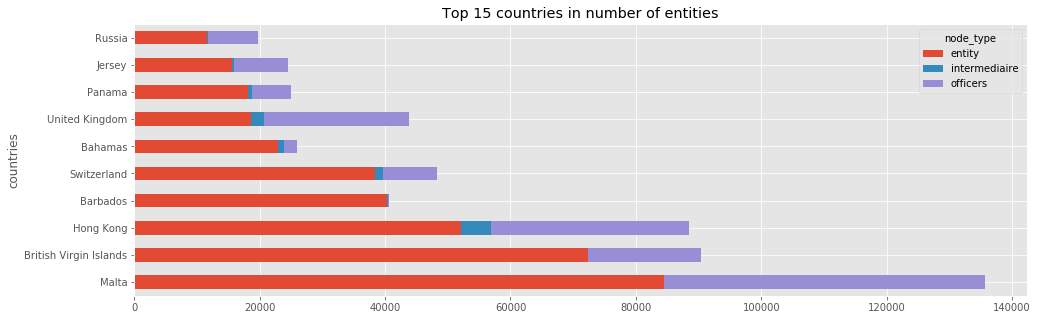

In [6]:
#count of countries using Addresses
countries_counts.sort_values('entity',ascending = False)[:10].plot.barh(stacked=True,title = 'Top 15 countries in number of entities',figsize=(16, 5))

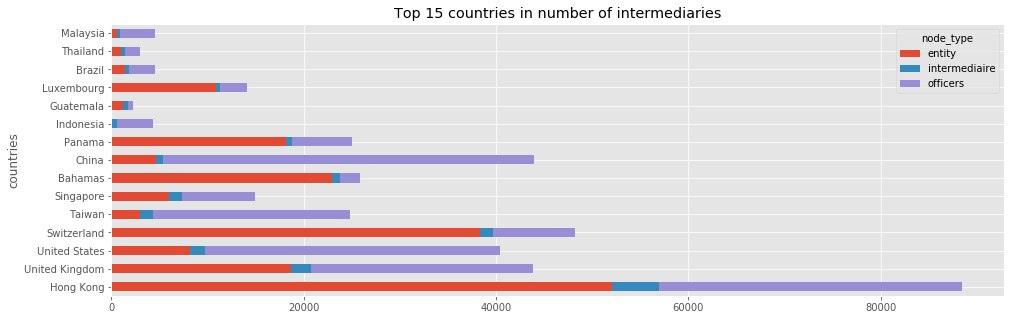

In [7]:
countries_counts.sort_values('intermediaire',ascending = False)[:15].plot.barh(stacked=True,title = 'Top 15 countries in number of intermediaries' ,figsize=(16, 5))

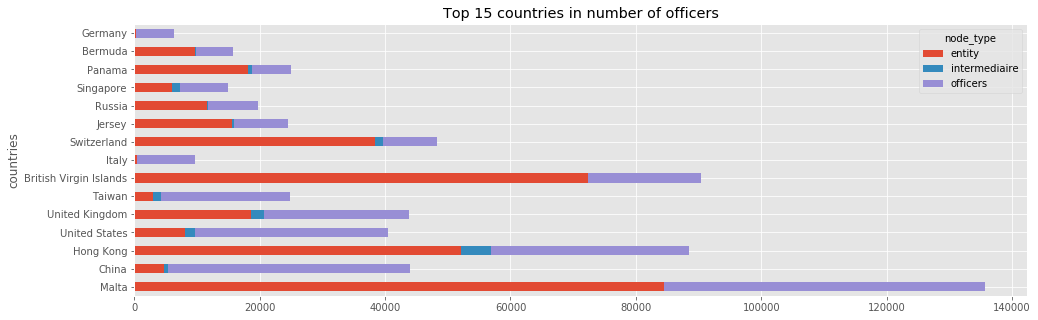

In [8]:
countries_counts.sort_values('officers',ascending = False)[:15].plot.barh(stacked=True,title = 'Top 15 countries in number of officers' ,figsize=(16, 5))

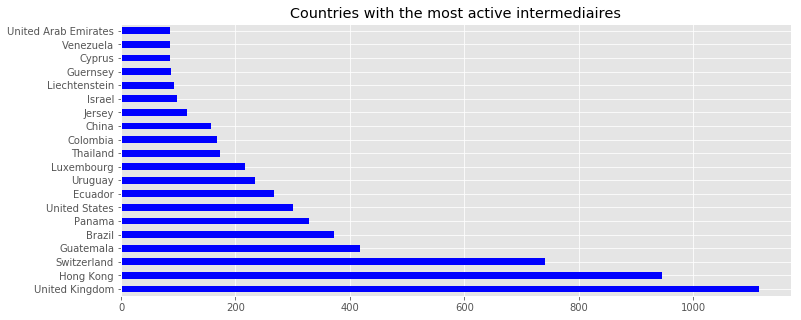

In [9]:
# Bar plot of most active intermediairies
intermediaries[intermediaries['status']== 'ACTIVE']['countries'].value_counts().head(20).plot.barh(
    title='Countries with the most active intermediaires', figsize=(12, 5), color = 'b'
)

In [10]:
# We will plot next the distribution of the evoluation of the incorposartions over the years
entities_date = entities[['incorporation_date', 'inactivation_date']].copy()
entities_date.dropna(inplace= True)

entities_date['incorporation_date'] = entities_date['incorporation_date'].apply(lambda x: parse(x))
entities_date['inactivation_date'] = entities_date['inactivation_date'].apply(lambda x: parse(x))

entities_date['incorporation_date'] = entities_date['incorporation_date'].apply(lambda x : x.year)
entities_date['inactivation_date'] = entities_date['inactivation_date'].apply(lambda x : x.year)

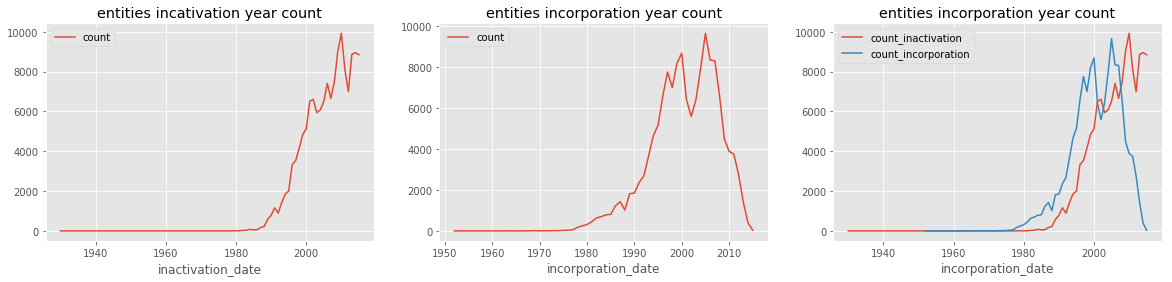

In [11]:
f, axarr = plt.subplots(1, 3, figsize=(20, 4))
f.subplots_adjust(hspace=0.75)

entities_date.groupby(['inactivation_date']).count().rename(columns= {'incorporation_date':'count'}).plot(
    title='entities incativation year count',  ax=axarr[0])

entities_date.groupby(['incorporation_date']).count().rename(columns= {'inactivation_date':'count'}).plot(
    title='entities incorporation year count',  ax=axarr[1])

entities_date.groupby(['inactivation_date']).count().rename(columns= {'incorporation_date':'count_inactivation'}).plot(
    title='entities incativation year count',  ax=axarr[2])

entities_date.groupby(['incorporation_date']).count().rename(columns= {'inactivation_date':'count_incorporation'}).plot(
    title='entities incorporation year count',  ax=axarr[2])



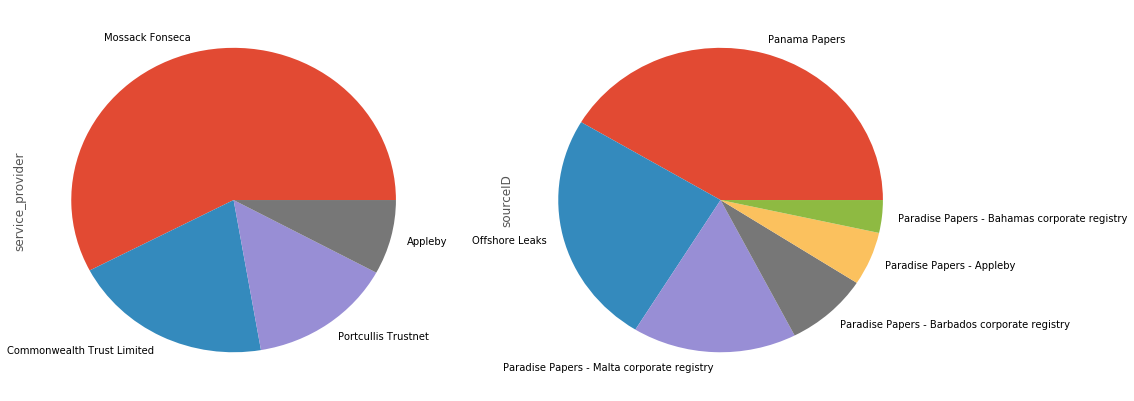

In [12]:
f, axarr = plt.subplots(1, 2, figsize=(16, 7))
f.subplots_adjust(hspace=0.75)

entities['service_provider'].value_counts().plot(kind='pie',  ax=axarr[0])
entities['sourceID'].value_counts()[:6].plot(kind='pie', ax= axarr[1])

In [112]:
edges_countries = edges[['START_ID', 'END_ID', 'TYPE']].merge(nodes,how='left', left_on='START_ID', right_on='node_id').rename(columns= 
                                        {'countries':'countries_start', 'node_id':'node_id_start', 'node_type': 'node_type_start'})
edges_countries = edges_countries[['START_ID','END_ID','countries_start', 'node_id_start', 'TYPE', 'node_type_start']].merge(nodes,how='left', left_on='END_ID', 
                                                            right_on='node_id').rename(columns= 
                                        {'countries':'countries_end', 'node_type': 'node_type_end' }).drop(['node_id_start', 'node_id'], axis= 1)

In [113]:
#nodes[nodes['START_ID']==14091035]

In [114]:
# We are going to focus our interest, entity, intermediaries, officers
edges_countries = edges_countries[edges_countries['node_type_start'].notnull()]
edges_countries = edges_countries[edges_countries['node_type_end'].notnull()]

In [115]:
edges_countries = edges_countries[edges_countries['countries_start'].notnull()]
edges_countries = edges_countries[edges_countries['countries_end'].notnull()]

In [116]:
edges_countries[["START_ID", "END_ID"]] = edges_countries[["START_ID", "END_ID"]].apply(pd.to_numeric)

In [117]:
edges_countries = edges_countries.drop_duplicates()

In [118]:
def add_rank(by_x):
    result = countries_counts.sort_values(by_x,ascending = False)
    result.reset_index(inplace = True)
    col = 'Rank_'+by_x
    result.index.name = col
    result.reset_index(inplace = True)
    result[col] = result[col] + 1
    return result[['countries',col]]

In [119]:
rank_by_entity = add_rank('entity')

In [120]:
rank_by_intermedaire = add_rank('intermediaire')

In [121]:
rank_by_officers = add_rank('officers')

In [122]:
edges_countries.head()

,START_ID,END_ID,countries_start,TYPE,node_type_start,countries_end,node_type_end
5310,11000001,10208879,South Africa,intermediary_of,intermediaire,South Africa,entity
5311,11000001,10198662,South Africa,intermediary_of,intermediaire,South Africa,entity
5312,11000001,10159927,South Africa,intermediary_of,intermediaire,South Africa,entity
5313,11000001,10165779,South Africa,intermediary_of,intermediaire,South Africa,entity
5314,11000001,10152967,South Africa,intermediary_of,intermediaire,South Africa,entity


In [94]:
nodes.dtypes

countries    object
node_id       int64
node_type    object
dtype: object

### Network analysis

In [123]:
unique_nodes_start = edges_countries[['node_type_start','START_ID']]
unique_nodes_start = unique_start.drop_duplicates()

In [124]:
unique_nodes_end = edges_countries[['node_type_end','END_ID']]
unique_nodes_end = unique_nodes_end.drop_duplicates()

In [125]:
unique = list(set(unique_nodes_start['START_ID']) | set(unique_nodes_end['END_ID']))

In [126]:
unique_nodes = nodes.loc[nodes['node_id'].isin(unique)]

In [127]:
G = nx.DiGraph()

for n,row in unique_df.iterrows():
    G.add_node(row.node_id, node_type=row.node_type) 

In [130]:
for n,row in edges_countries.iterrows():
    G.add_edge(row.START_ID, row.END_ID, rel_type=row.TYPE)

In [131]:
print('Number of nodes = ', G.number_of_nodes())
print('Number of edges = ', G.number_of_edges())

Number of nodes =  526825
Number of edges =  658795


In [132]:
degree_centrality = nx.degree_centrality(G)

In [140]:
#degree_centrality

In [ ]:
## page rank

In [ ]:
nodes = G.nodes()
g_degree = G.degree()
types = [G.node[n]["node_type"] for n in nodes]
countries = [n for n in nodes]
degrees = [g_degree[n] for n in nodes]
node_degree = pd.DataFrame(data={"countries":countries,"node_type":types, "degree":degrees})

In [ ]:
## remove countries = Not identified

In [ ]:
node_degree.node_type.unique()

In [ ]:
node_degree[node_degree.node_type=='intermediaire'].sort_values('degree',ascending = False)

In [ ]:
pr = nx.pagerank_scipy(G)

In [ ]:
node_degree["page_rank"] = node_degree.countries.map(lambda x: pr[x])


In [ ]:
node_degree[node_degree.node_type == "entities"].sort_values("page_rank", ascending=False)


In [ ]:
## Focus on Hong kong and switzerland ? top degree and top rank

In [ ]:
subgraphs = [g for g in nx.connected_component_subgraphs(G.to_undirected())]


In [ ]:
subgraphs = sorted(subgraphs, key=lambda x: x.number_of_nodes(), reverse=True)


In [ ]:
plot_graph(subgraphs[0],label_edges= True)

In [ ]:
#########################

In [ ]:
#Corruption Perceptions Index dataframe 
cpi = pd.read_csv(data_folder + 'cpi.csv')
cpi = cpi[['CPI Rank', 'Country', 'Country Code', 'Corruption Perceptions Index (CPI)']]

In [ ]:
cpi.head()

In [ ]:
fsi = pd.read_excel(data_folder + 'fsi.xlsx')

# the heigher the fsi score the more secretive the jurisdiction  
# Global Scale Weight5	 : take into account the jurisdiction's size and overall importance the global market of offshore financial service
fsi.drop(['FSI Value6', 'Narrative Report', 'FSI Share7'], axis=1, inplace= True)
fsi.rename(columns={'Secrecy Score4': 'secrecy_score','Global Scale Weight5':'global_scale'}, inplace= True)
# difference between cpi and fsi : https://www.financialsecrecyindex.com/infographics/FSI_vs_CPI-Final.pdf?fbclid=IwAR3xs9rvQopxfFB62025cFQgIflZtoonYLCKP9ykv4QvGJHie4LN-VoMfuY
fsi = fsi.dropna()
fsi.head()

In [ ]:
# anti money laundring
aml = pd.read_csv(data_folder + 'aml.csv')

In [ ]:
aml.drop(['ISO Code', 'Change in score 2017-2018'], axis = 1, inplace=True)

##########################################

In [ ]:
nodes.head()